# Solving the TSP

In order to solve the TSP on a graph $G=(V, E)$ we augment the 2-matching formulation introduced previously to include *connectivity constraints*
$$
x(\delta(S)) \geq 2 \quad \forall \: \emptyset \neq S \subsetneq V.
$$
Since there is an exponential number of these constraints, we *separate* them using a constraint handler.


In [2]:
import pyscipopt
from pyscipopt import Model, quicksum

import numpy as np
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
matplotlib.rcParams['axes.titlesize'] = 20

In [3]:
n = 40

np.random.seed(42)
coordinates = np.random.random((n, 2))

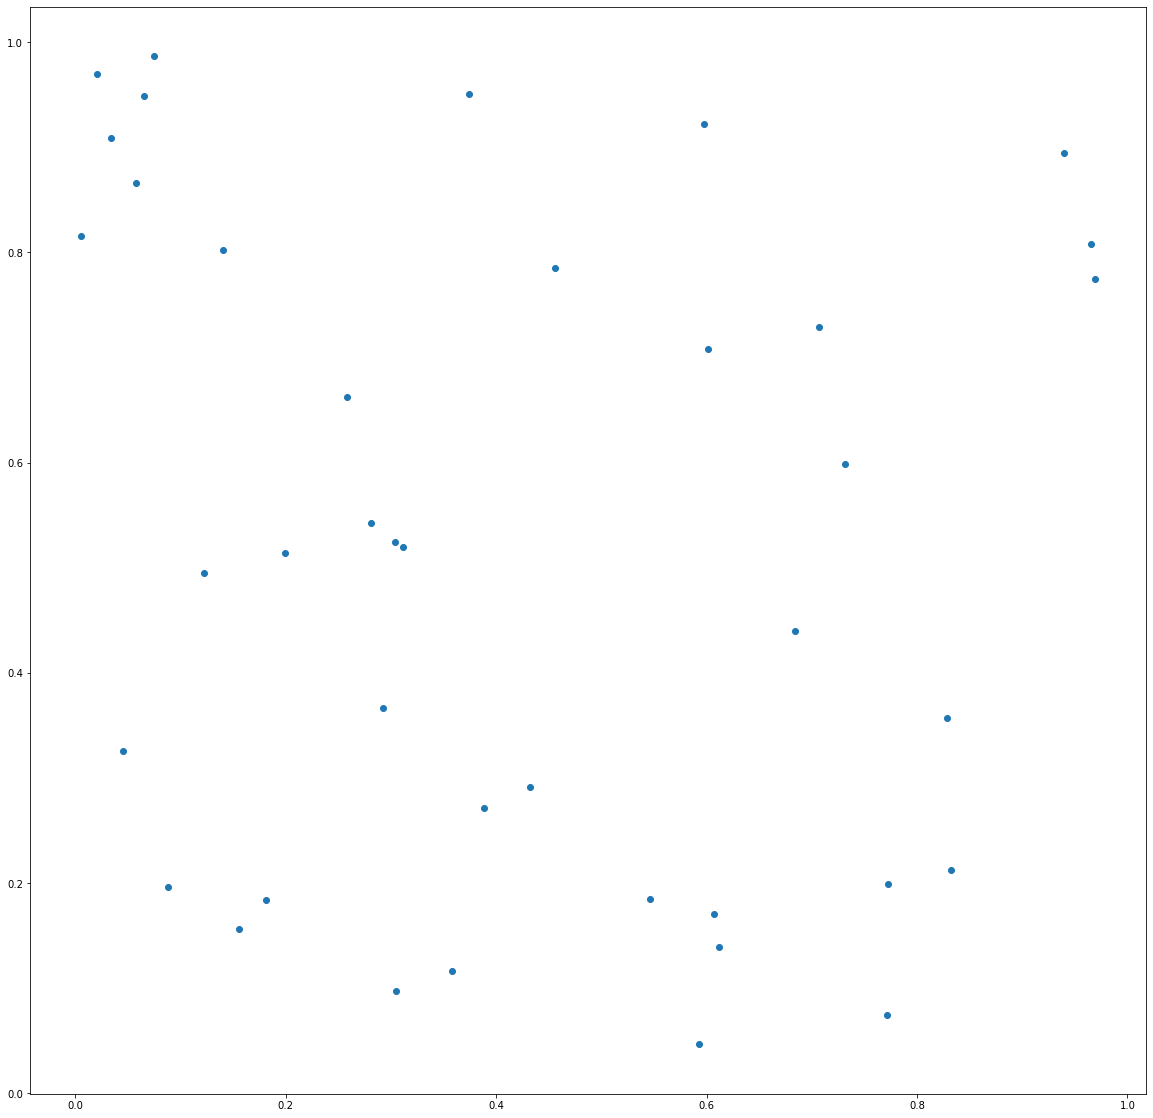

In [4]:
plt.scatter(coordinates[:, 0], coordinates[:,1])

# 2-Matching formulation

In [4]:
def vertices(n):
    return range(n)

def edges(n):
    return [(i, j) for i in vertices(n) for j in vertices(n) if i < j]

In [5]:
G = nx.DiGraph(edges(n))

In [6]:
def dist(coordinates, i, j):
    dx = coordinates[i, 0] - coordinates[j, 0]
    dy = coordinates[i, 1] - coordinates[j, 1]
    return np.hypot(dx, dy)

In [7]:
def create_variables(model, graph, coordinates):
    return {edge:model.addVar(name=f"x_{edge}", vtype="B", obj=dist(coordinates, *edge)) 
            for edge in graph.edges}


In [8]:
def create_constraints(model, graph, variables, **props):
    cons = {}
    for v in graph:
        cons[v] = model.addCons(quicksum((variables[edge] for edge in graph.out_edges([v]))) +
                                quicksum((variables[edge] for edge in graph.in_edges([v]))) == 2, 
                                **props)
    
    return cons
        

In [9]:
model = Model()
model.redirectOutput()

variables  = create_variables(model, G, coordinates)

_ = create_constraints(model, G, variables)

In [10]:
model.optimize()

model.getStatus()

presolving:
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
   (0.0s) probing: 51/780 (6.5%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.0s) no symmetry present
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 780 variables (780 bin, 0 int, 0 impl, 0 cont) and 40 constraints
     40 constraints of type <linear>
Presolving Time: 0.03

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
p 0.1s|     1 |     0 |     0 |     - |   locks|   0 | 780 |  50 |  40 |   0 |  0 |  10 |   0 | 0.000000e+00 |

'optimal'

In [11]:
solution = [edge for (edge, variable) in variables.items() if round(model.getVal(variable)) == 1]

In [12]:
def plot_sol(sol, coordinates):
    x = coordinates[:,0]
    y = coordinates[:,1]
    lines = [[(x[i], y[i]), (x[j], y[j])] for (i, j) in solution]

    plt.scatter(x, y)

    lc = matplotlib.collections.LineCollection(lines, linewidths=2)

    ax = plt.gca()

    ax.add_collection(lc)
    ax.autoscale()
    
    obj = sum(dist(coordinates, *edge) for edge in sol)
    plt.title(f"A solution with objective {obj}")
    
    plt.show()


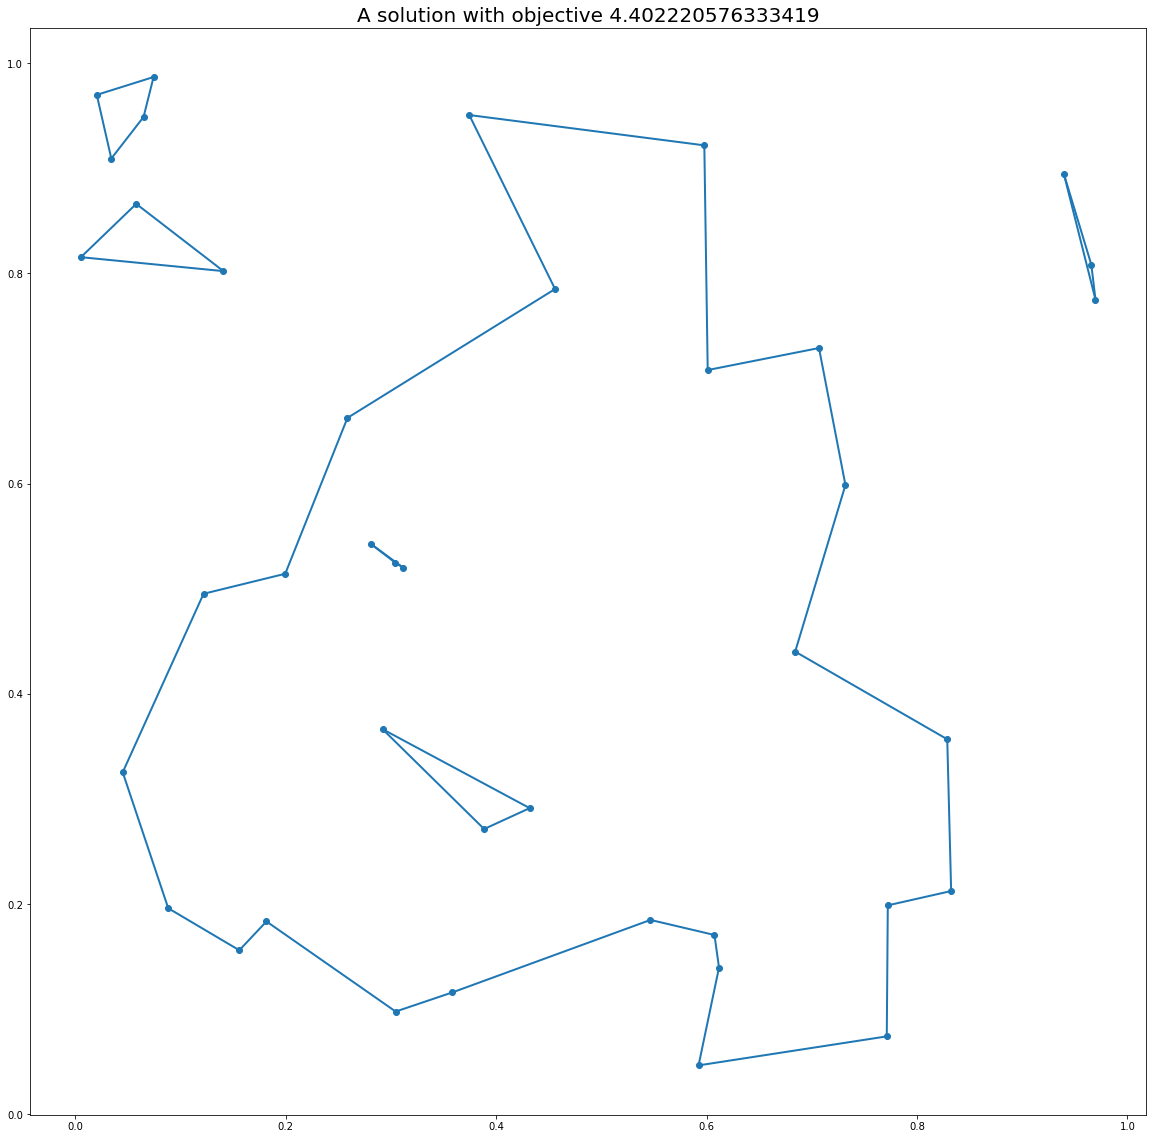

In [13]:
plot_sol(solution, coordinates)

# Adding a custom constraint handler for subtour elimination

In [14]:
class ConnectivityConshdlr(pyscipopt.scip.Conshdlr):
    
    def __init__(self, model, graph, variables):
        self.model = model
        self.graph = graph
        self.variables = variables
    
    def conslock(self, constraint, locktype, nlockspos, nlocksneg):
        '''variable rounding lock method of constraint handler'''

        for (edge, variable) in self.variables.items():
            self.model.addVarLocks(variable, nlockspos, nlocksneg)

        return {}
    
    def consenfolp(self, constraints, nusefulconss, solinfeasible):
        '''calls enforcing method of constraint handler for LP solution for all constraints added'''
        
        (v, p) = self.min_cut(any_cut=False)
        
        row = self.model.createEmptyRowUnspec(lhs = 2., rhs = np.inf)
        
        if p is None:
            return {"result": pyscipopt.SCIP_RESULT.FEASIBLE}
        
        (reachable, non_reachable) = p
        cutset = set()
        
        for u, nbrs in ((n, G[n]) for n in reachable):
            cutset.update((u, v) for v in nbrs if v in non_reachable)
            
        for u, nbrs in ((n, G[n]) for n in non_reachable):
            cutset.update((u, v) for v in nbrs if v in reachable)
            
        
        model.addCons(quicksum(self.variables[edge] for edge in cutset) >= 1)
        return {}

    def consenfops(self, constraints, nusefulconss, solinfeasible, objinfeasible):
        '''calls enforcing method of constraint handler for pseudo solution for all constraints added'''
        
        (v, p) = self.min_cut(any_cut=True)
        
        result = pyscipopt.SCIP_RESULT.FEASIBLE if p is None else pyscipopt.SCIP_RESULT.INFEASIBLE    

        return {"result": result}

    def conscheck(self, constraints, solution, checkintegrality, checklprows, printreason, completely):
        '''calls feasibility check method of constraint handler '''
        
        (v, p) = self.min_cut(any_cut=True)
        
        result = pyscipopt.SCIP_RESULT.FEASIBLE if p is None else pyscipopt.SCIP_RESULT.INFEASIBLE    

        return {"result": result}
    
    def min_cut(self, any_cut):
        
        nx.set_edge_attributes(self.graph, self.fractional_values(), "capacity")
        
        is_feasible = True
        
        v_min = np.inf
        p_min = None
        
        for s in self.graph:
            for t in self.graph:
                if t <= s:
                    continue
                    
                (v, p) = nx.minimum_cut(self.graph.to_undirected(), s, t)
                
                if self.model.isGE(v, 2.):
                    continue
                
                if any_cut: 
                    return (v, p)
                
                if self.model.isLT(v, v_min):
                    (v_min, p_min) = (v, p)
        
        return (v_min, p_min)
        
    
    def fractional_values(self):
        return  {edge: model.getSolVal(None, variable) for (edge, variable) in self.variables.items()}
    


In [15]:
model = Model()
model.redirectOutput()

variables  = create_variables(model, G, coordinates)

_ = create_constraints(model, G, variables)

conshdlr = ConnectivityConshdlr(model, G, variables)


model.includeConshdlr(conshdlr, "Connectivity", "Enforces connectivity constraints",
                      sepapriority = 1, enfopriority = 1, chckpriority = 1, sepafreq = 10, propfreq = 50,
                      eagerfreq = 1, maxprerounds = -1, delaysepa = False, delayprop = False, needscons = False,
                      presoltiming = pyscipopt.SCIP_PRESOLTIMING.FAST, proptiming = pyscipopt.SCIP_PROPTIMING.BEFORELP)

In [16]:
model.optimize()

model.getStatus()

presolving:
   (0.0s) probing: 51/780 (6.5%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.0s) no symmetry present
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 780 variables (780 bin, 0 int, 0 impl, 0 cont) and 40 constraints
     40 constraints of type <linear>
Presolving Time: 0.03

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.1s|     1 |     0 |    64 |     - |  7266k |   0 | 780 |  50 |  40 |   0 |  0 |  10 |   0 | 4.339424e+00 |      --      |    Inf | unknown
  0.3s|     1 |     0 |    89 |     - |

'optimal'

In [17]:
solution = [edge for (edge, variable) in variables.items() if round(model.getVal(variable)) == 1]

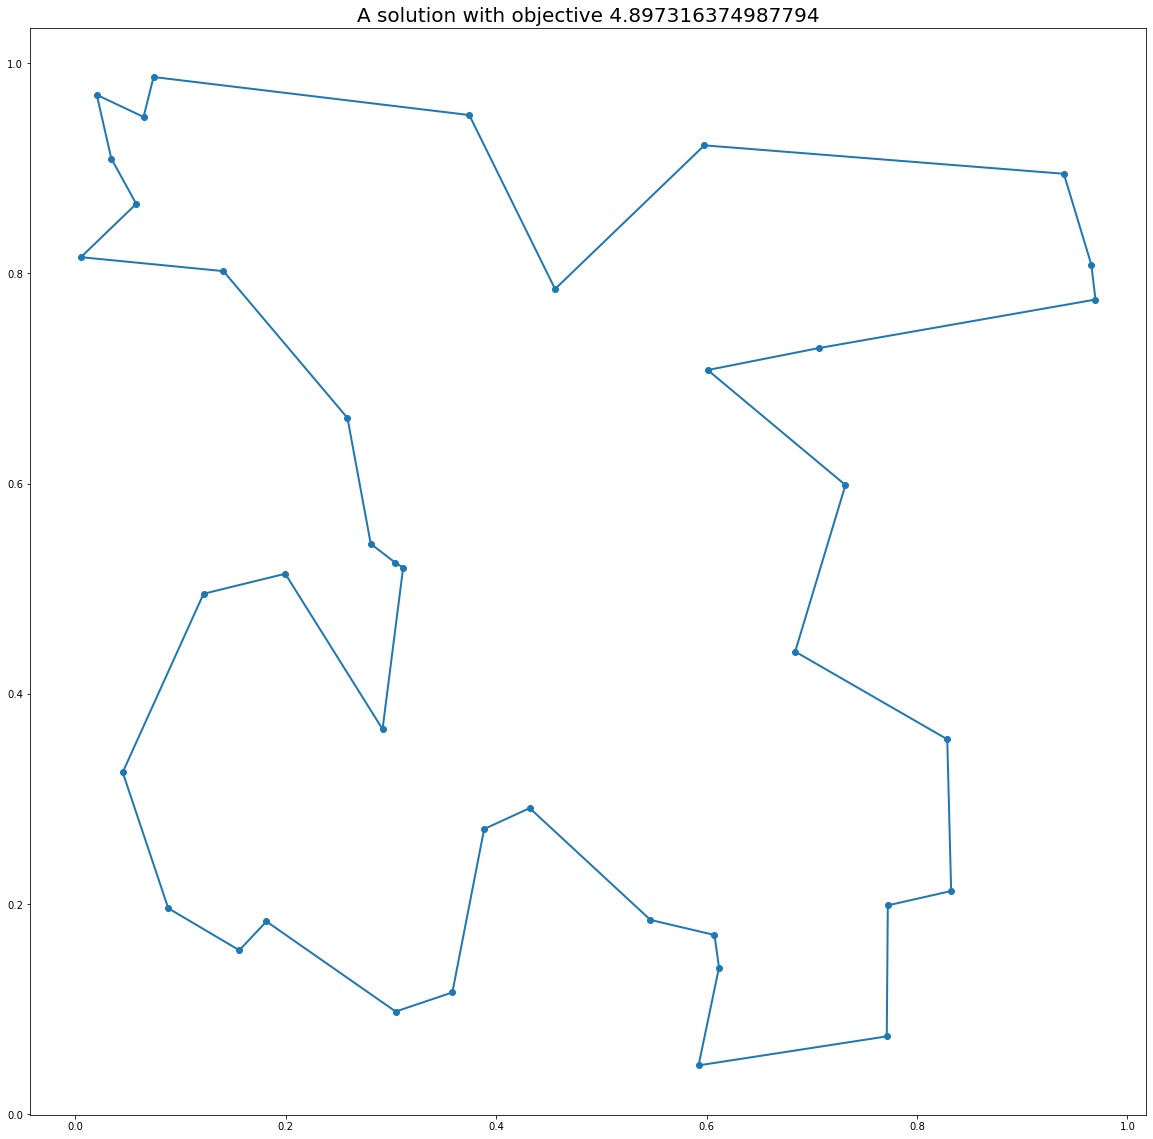

In [18]:
plot_sol(solution, coordinates)